# Modelado de la función sinusoidal con NeuralODEs

In [89]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions
using Flux.Data: DataLoader, Flux

Para esto tenémos que crear una ecuación diferencial parametrizada que me permita aprender la solución que buscamos. En este caso le damos a la NeuralODE una dinámica que es una combinación de funciones periódicas, con esto la NeuralODE debería ser capaz de entrenar los parámetros para poder llegar al resultado correcto.

In [90]:
function parametric_ode_system!(du,u,p,t)
    y = u
    ω, A, B = p
    du[1] = dy = A*cos(ω*2π*t) + B*sin(ω*2π*t)
  end;

Ahora seteamos el tiempo de simulación y los parámetros de la ecuación diferencial, como así la condición inicial del problema la cual es la posición inicial en 0.

In [91]:
tbegin = 0
tstep = 0.01
tend = 5
trange = tbegin:tstep:tend
t_train = Float32.(hcat(trange...))
y_train = Float32.(sin.(2π*trange))
data = DataLoader((t_train, y_train); batchsize=20, shuffle=true)
p = ones(3)
tspan = (tbegin, tend)
u0 = Float32[0.0];

Creamos el problema de ecuaciones diferenciales parametrizado. Además creamos lo que sería nuestra red neuronal que consiste en el resolvedor de ODEs.

In [123]:
prob = ODEProblem(parametric_ode_system!, u0, tspan, p)
n_ode = NeuralODE(parametric_ode_system!, Tsit5(), saveat=trange)
model = Chain((x, p = n_ode.p) -> n_ode(x,p), Array)

function net()
    model(u0) 
end
sol = net()

MethodError: MethodError: no method matching promote_tspan(::Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False})

Closest candidates are:
  promote_tspan(::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any)
   @ DiffEqBase C:\Users\Propietario\.julia\packages\DiffEqBase\rVTlI\src\init.jl:2
  promote_tspan(!Matched::Tuple{T, S}) where {T, S}
   @ SciMLBase C:\Users\Propietario\.julia\packages\SciMLBase\GmToj\src\problems\problem_utils.jl:7
  promote_tspan(!Matched::Number)
   @ SciMLBase C:\Users\Propietario\.julia\packages\SciMLBase\GmToj\src\problems\problem_utils.jl:8
  ...


Generamos los datos de entrenamiento y datos de prueba de la función sinusoidal con ruido gaussiano

In [118]:
function sine_with_noise(t)
    return sin(2π*t) + rand(Normal(0,0.1))
end;

In [119]:
dataset_outs = sine_with_noise.(trange)
test_dataset = sine_with_noise.(trange)

501-element Vector{Float64}:
  0.08462626706756243
 -0.0732350493854922
  0.22468920951002752
  0.18571959599283
  0.09417145676216535
  0.2996612154116696
  0.3145725732158953
  0.6300975435661708
  0.5402710464952565
  0.44910420466853673
  ⋮
 -0.6451125162672581
 -0.47656067469966196
 -0.2812146277698364
 -0.20900353893042284
 -0.1868157796303383
 -0.09145457461757676
 -0.24645030156818887
  0.013142373041356098
 -0.13170367791043536

Graficamos hora sí tanto solución de la ecuación diferencial como los datos de entrenamiento. Esto dependiendo de las condiciones iniciales aleatorias que se setearon puede estar cerca o lejos de la función sinusoidal con ruido

In [120]:
scatter(trange, dataset_outs, label = "Training Data")
scatter!(trange, test_dataset, label = "Test Data")
scatter!(trange, sol, label = "Sol")

ErrorException: Cannot convert NeuralODE{ODEProblem{Vector{Float32}, Tuple{Int64, Int64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(parametric_ode_system!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Vector{Bool}, Optimisers.Restructure{ODEProblem{Vector{Float32}, Tuple{Int64, Int64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(parametric_ode_system!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tuple{}}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Tuple{}, Base.Pairs{Symbol, AbstractVector, Tuple{Symbol, Symbol}, NamedTuple{(:u0, :saveat), Tuple{Vector{Float32}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}}} to series data for plotting

Creamos la función loss que es la diferencia entre la solución de la ecuación diferencial y los datos de entrenamiento

In [111]:
function loss_func()
    pred = net()
    sum(abs2, dataset_outs .- pred)
  end;

In [112]:
function loss_func2()
    pred = net()
    sum(abs2, test_dataset .- pred)
  end

loss_func2 (generic function with 1 method)

Creamos una función para ver la predicción de la red neuronal en cada época

In [113]:
function accuracy(y)
    num_correct = 0
    predictions = net()
    for i in 1:length(predictions)
        if abs(predictions[i] - y[i]) < 0.2
            num_correct += 1
        end
    end
    return (num_correct/length(predictions)) * 100.0
end;

Ahora entrenamos la red durante 150 épocas con el método de optimización Adam y un learning rate de 0.1, además en cada época guardamos los datos del loss y la presición

In [114]:
epochs = 150
learning_rate = 0.1
data = Iterators.repeated((), epochs)
opt = ADAM(learning_rate)
iter = 0
losses = []
losses_test = []
accuracys = []
accuracys_test = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_func()
  println("Epoch: $iter | Loss: $actual_loss")
  push!(losses, actual_loss)
  push!(losses_test, loss_func2())
  push!(accuracys, accuracy(dataset_outs))
  push!(accuracys_test, accuracy(test_dataset))
  #plt = plot(solve(remake(prob, p=p), Tsit5()))
  #scatter!(trange, dataset_outs)
  #display(plt)
  #display(plot(solve(remake(prob,p=p),Tsit5()));
  #        scatter!(trange,dataset_outs))
end
fparams = Flux.params(p)

cb()

Flux.train!(loss_func, fparams, data, opt, cb=cb)

MethodError: MethodError: no method matching getindex(::NeuralODE{ODEProblem{Vector{Float32}, Tuple{Int64, Int64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(parametric_ode_system!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Vector{Bool}, Optimisers.Restructure{ODEProblem{Vector{Float32}, Tuple{Int64, Int64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(parametric_ode_system!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tuple{}}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Tuple{}, Base.Pairs{Symbol, AbstractVector, Tuple{Symbol, Symbol}, NamedTuple{(:u0, :saveat), Tuple{Vector{Float32}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}}}, ::Int64, ::Colon)

Una vez entrenada la NeuralODE, lo que hacemos es graficar los datos de entenamiento y los de la predicción de la red neuronal. Como se puede ver la red neuronal aprendió la función sinusoidal con ruido. Para esto lo que se logró es que los parámetros se actualicen de tal forma de que la solución de la ecuación diferencial se acerque a los datos de entrenamiento. Es por esto que volvemos a resovler el problema con los nuevos parámetros actualizados $p$

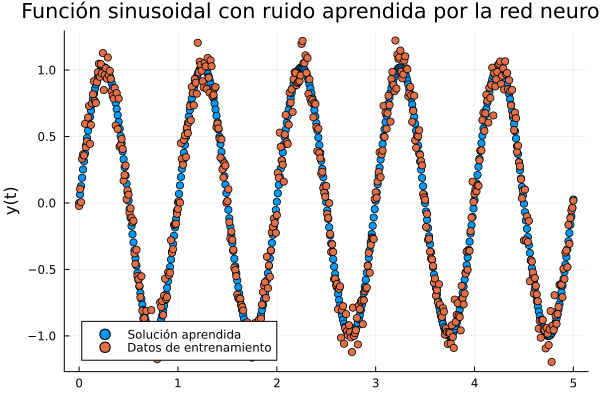

In [100]:
sol = net()
scatter(trange, sol, label = "Solución aprendida", title = "Función sinusoidal con ruido aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, dataset_outs, label = "Datos de entrenamiento")

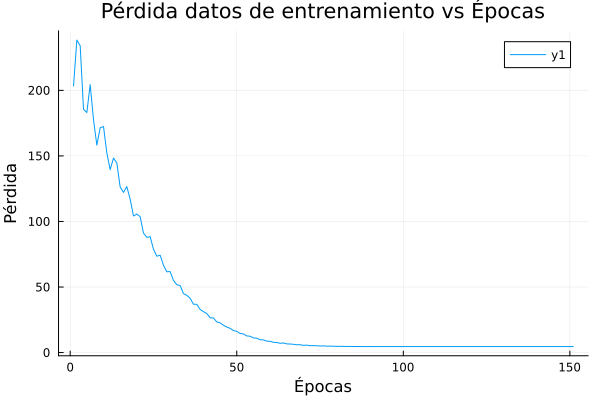

In [101]:
plot(losses, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de enetrenamiento: 96.6067864271457


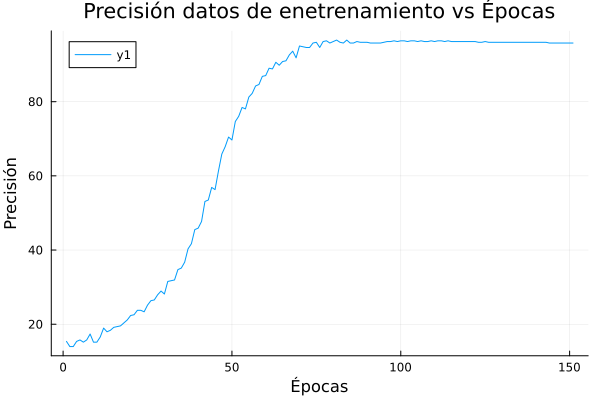

In [102]:
println("Maxima precisión en datos de enetrenamiento: ", maximum(accuracys))
plot(accuracys, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de enetrenamiento vs Épocas")

# Veamos con los datos de prueba

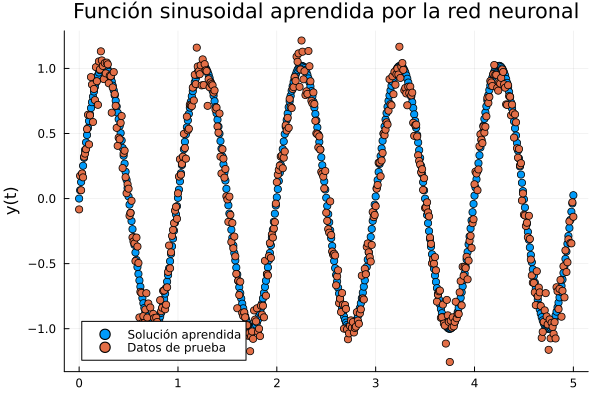

In [103]:
scatter(trange, sol, label = "Solución aprendida", title = "Función sinusoidal aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, test_dataset, label = "Datos de prueba")

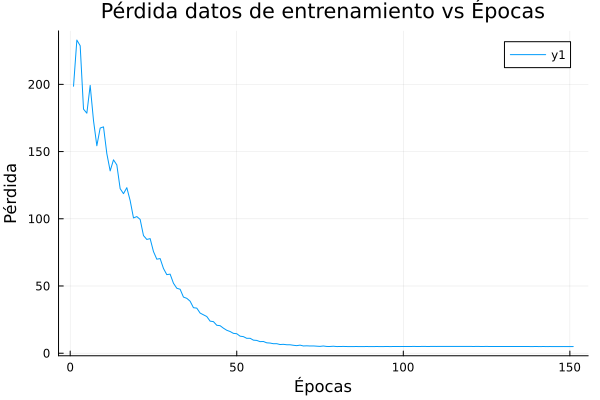

In [104]:
plot(losses_test, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de prueba: 96.20758483033931


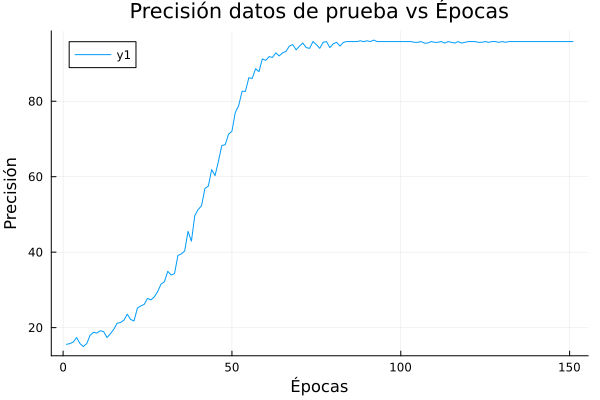

In [105]:
println("Maxima precisión en datos de prueba: ", maximum(accuracys_test))
plot(accuracys_test, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de prueba vs Épocas")

Como vemos esta NeuralODE comparada con los métodos anteriores mejora la presición en los datos de entrenamiento comparada con la red de varias capas que se creó con la red neuronal Feedfoward. Sin embargo esto depende mucho de las condiciones iniciales que se le de a la ecuación diferencial.